# Classification ignition point 

# Structure 

| Column name | Definition | Unit |
|--------|-----------|--------|
| `ignition`   | Target column| Boolean: {1,0} |
| `distance_{feature}` | Distance to nearest feature  |  Meters (m) |
| vegetation class: from `cropland` to `wetland`  |  Ratio of each of the vegetation classes  under which the ignition or non-ignition point lies    |  No unit (between 0 and 1)  |
| `aspect`  |  Orientation of the slope    |  Degrees (°)  |
| `elevation`  |  elevation value    |  Meters  |
| `slope`  |  Slope value    |  Degrees (°)  |
| `pop_dens`  |  Population density value    |  Persons per km2  |
| `max_temp`  |  Maximum temperature of the day    |  Degrees celsius (°C)  |
| `avg_temp`  |  Average temperature of the day   |  Degrees celsius (°C)  |
| `max_wind_vel`  |  Maximum wind velocity of the day    |  Meters per second (m/s)  |
| `avg_wind_angle`  |  Average angle of the vector wind over the day    |  Degrees (°)  |
| `avg_rel_hum`  |  Average relative humidity over the day    |  %  |
| `avg_soil`  |  Average soil moisture of the day    |  m3/m3  |
| `sum_prec`  |  Cumulative rainfall precipitation of the day    |  Millimeters (mm)  |
| `yearly_avg_temp`  |  Average temperature over the year    |  Degrees celsius (°C)  |
| `anom_{feature}`  |  Standardized anomaly of weather for the given day over the last 30 years. When the anomaly is positive, it means that the feature value is greater that the 30-year average    |  No unity |
| `forest`  |  Sum of all the columns where the names start with `forest`   |  No unit  |
| `vegetation_class`  |  Vegetation with the max occurrence in the vicinity of the ignition/non-ignition point    |  Without unit  |
| `Year`  |  Year of ignition    |  Without unit  |
| `max_max_temp`  |  Missing information    |  Missing information  |



# Task

### Libraries

In [1]:
# Importation des librairies
import os
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
import random
from random import seed as random_seed

from tqdm import tqdm
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.random import set_seed as tf_set_seed

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Configuration pour éviter les avertissements
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Exploration des données

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22035 entries, 0 to 22034
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     22035 non-null  object 
 1   distance_fire_stations   22030 non-null  float64
 2   distance_rivers          22030 non-null  float64
 3   distance_roads           22030 non-null  float64
 4   distance_powerlines      22030 non-null  float64
 5   cropland                 22030 non-null  float64
 6   forest_deciduous_broad   22030 non-null  float64
 7   forest_deciduous_needle  22030 non-null  float64
 8   forest_evergreen_broad   22030 non-null  float64
 9   forest_evergreen_needle  22030 non-null  float64
 10  forest_mixed             22030 non-null  float64
 11  forest_unknown           22030 non-null  float64
 12  herbaceous_vegetation    22030 non-null  float64
 13  moss_lichen              22030 non-null  float64
 14  shrubland                22

In [8]:
df["Date"] = pd.to_datetime(df["Date"])

In [9]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Date,22035,2011-10-10 20:17:32.797821696,2001-07-01 00:00:00,2006-11-02 12:00:00,2012-02-14 00:00:00,2016-08-26 00:00:00,2021-06-28 00:00:00,NaN
distance_fire_stations,22030.0,23646.387792,0.0,9568.829605,18494.931738,32310.988843,110474.261708,19248.657525
distance_rivers,22030.0,5966.777537,0.0,707.106781,2610.076627,8384.323013,43784.986011,7515.660146
distance_roads,22030.0,5152.597702,0.0,250.0,1581.13883,7941.190087,40094.419811,6924.754655
distance_powerlines,22030.0,30127.951951,0.0,8265.137627,20846.161854,41340.053217,159274.919557,30099.446768
cropland,22030.0,0.006415,0.0,0.0,0.0,0.0,1.0,0.057848
forest_deciduous_broad,22030.0,0.013557,0.0,0.0,0.0,0.0,1.0,0.088239
forest_deciduous_needle,22030.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
forest_evergreen_broad,22030.0,0.326108,0.0,0.0,0.0,0.916667,1.0,0.43312
forest_evergreen_needle,22030.0,-4584.657286,-100000.0,0.0,0.0,0.0,0.0,20915.699938


In [10]:
df['vegetation_class'].unique()

array(['forest', 'wetland', 'herbaceous_vegetation', 'Forestt',
       'shrubland', 'water', 'urban', nan, '$herb$aceous_vegetation'],
      dtype=object)

On constate ici que les variables : (`forest`, `Forestt`) et (`herbaceous_vegetation`, `$herb$aceous_vegetation`) semblent être une simple faute d'orthographe. On peut commencer par étudier ces deux variables pour voir si on retrouve des incohérences.

In [11]:
df[df["vegetation_class"]=='$herb$aceous_vegetation']

,Date,distance_fire_stations,distance_rivers,distance_roads,distance_powerlines,cropland,forest_deciduous_broad,forest_deciduous_needle,forest_evergreen_broad,forest_evergreen_needle,...,avg_wind_angle,avg_rel_hum,avg_soil,sum_prec,forest,vegetation_class,Year,max_max_temp,yearly_avg_temp,ignition
22034,2016-01-21,41926.274578,707.106781,3092.329219,39957.790229,0.0,0.0,0.0,0.0,0.0,...,19.732412,75.858948,0.332093,5.220248,0.0,$herb$aceous_vegetation,2016,54.935205,NaN,0


In [12]:
df[df["vegetation_class"]=='herbaceous_vegetation']

,Date,distance_fire_stations,distance_rivers,distance_roads,distance_powerlines,cropland,forest_deciduous_broad,forest_deciduous_needle,forest_evergreen_broad,forest_evergreen_needle,...,avg_wind_angle,avg_rel_hum,avg_soil,sum_prec,forest,vegetation_class,Year,max_max_temp,yearly_avg_temp,ignition
6,2001-08-01,1500.000000,1581.138830,750.000000,1750.000000,0.0,0.0,0.0,0.000000,0.0,...,225.296082,53.998550,0.154567,0.034456,0.000000,herbaceous_vegetation,2001,72.606183,NaN,1
11,2003-06-29,6010.407640,1903.943276,1030.776406,28439.629041,0.0,0.0,0.0,0.000000,0.0,...,25.281057,66.931328,0.211325,0.395937,0.000000,herbaceous_vegetation,2003,66.126007,14.985618,1
13,2005-01-29,29319.362203,6373.774392,1250.000000,500.000000,0.5,0.0,0.0,0.000000,0.0,...,105.670219,61.700409,0.136492,0.516819,0.000000,herbaceous_vegetation,2005,70.167730,14.963572,1
20,2004-12-06,15041.608956,1750.000000,1250.000000,80195.464336,0.0,0.0,0.0,0.000000,0.0,...,134.463531,69.509018,0.097249,0.000000,0.000000,herbaceous_vegetation,2004,60.440726,NaN,1
23,2003-02-18,8139.410298,6600.189391,2000.000000,73236.346850,0.0,0.0,0.0,0.000000,0.0,...,206.147507,69.565575,0.090911,0.000000,0.000000,herbaceous_vegetation,2003,67.657003,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22002,2011-11-21,34173.271719,1767.766953,4366.062299,23730.254950,0.0,0.0,0.0,0.000000,0.0,...,342.713959,85.939049,0.302836,1.864031,0.000000,herbaceous_vegetation,2011,50.184589,NaN,0
22006,2009-01-30,4949.747468,500.000000,250.000000,10371.234256,0.0,0.0,0.0,0.083333,0.0,...,34.454945,78.585991,0.385847,1.415752,0.250000,herbaceous_vegetation,2009,52.519915,15.004861,0
22007,2009-12-06,10262.187876,4750.000000,353.553391,12903.487901,0.0,0.0,0.0,0.000000,0.0,...,285.136963,79.801521,0.277681,0.040176,0.000000,herbaceous_vegetation,2009,70.601140,14.921958,0
22009,2002-04-04,73239.333694,4100.304867,5000.000000,42019.340785,0.0,0.0,0.0,0.000000,0.0,...,118.389893,72.674019,0.261503,2.837494,0.000000,herbaceous_vegetation,2002,60.709382,NaN,0


In [13]:
df[df["vegetation_class"] == 'herbaceous_vegetation'].describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Date,3850,2011-10-08 07:41:55.324675584,2001-07-01 00:00:00,2006-10-26 00:00:00,2012-02-25 00:00:00,2016-08-12 00:00:00,2021-06-28 00:00:00,NaN
distance_fire_stations,3850.0,21051.747594,250.0,6485.560886,12806.248475,29200.813109,90234.416937,20572.641495
distance_rivers,3850.0,1758.368594,0.0,353.553391,1000.0,2371.708245,20651.876428,2005.138474
distance_roads,3850.0,1958.638696,0.0,250.0,559.016994,1581.13883,24744.94898,3766.349659
distance_powerlines,3850.0,21925.164051,0.0,4828.301979,14968.715051,29493.642469,139579.726322,24716.254268
cropland,3850.0,0.025671,0.0,0.0,0.0,0.0,0.833333,0.103512
forest_deciduous_broad,3850.0,0.004913,0.0,0.0,0.0,0.0,0.416667,0.031547
forest_deciduous_needle,3850.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
forest_evergreen_broad,3850.0,0.022706,0.0,0.0,0.0,0.0,0.416667,0.067203
forest_evergreen_needle,3850.0,-4155.844156,-100000.0,0.0,0.0,0.0,0.0,19960.382257


J'ai pas l'impression qu'il n'y ai d'incohéerence, donc je peux regrouper ces deux valeurs ensembles. Faisons pareil pour la variable forest.

In [14]:
df[df["vegetation_class"]=='forest']

,Date,distance_fire_stations,distance_rivers,distance_roads,distance_powerlines,cropland,forest_deciduous_broad,forest_deciduous_needle,forest_evergreen_broad,forest_evergreen_needle,...,avg_wind_angle,avg_rel_hum,avg_soil,sum_prec,forest,vegetation_class,Year,max_max_temp,yearly_avg_temp,ignition
0,2015-11-19,13287.682266,7211.102551,1250.000000,30196.233209,0.0,0.000000,0.0,1.000000,0.0,...,225.773605,56.837185,0.297854,0.360376,1.000000,forest,2015,62.552337,14.994683,1
1,2003-02-17,8721.381771,2358.495283,250.000000,13768.169813,0.0,0.000000,0.0,0.416667,0.0,...,209.708847,61.120739,0.264534,0.020176,0.833333,forest,2003,60.787457,15.053698,1
2,2012-02-26,10796.411441,0.000000,2015.564437,6254.998002,0.0,0.000000,0.0,0.666667,0.0,...,76.341278,63.017559,0.208871,0.025395,1.000000,forest,2012,63.420256,15.001883,1
4,2003-03-19,9905.806378,0.000000,1903.943276,6427.480066,0.0,0.000000,0.0,0.750000,0.0,...,316.951508,56.103680,0.208831,0.119717,0.916667,forest,2003,69.570496,NaN,1
5,2002-10-27,9219.544457,1802.775638,790.569415,78556.508324,0.0,0.000000,0.0,1.000000,0.0,...,200.360794,65.752640,0.149636,1.249126,1.000000,forest,2002,71.757874,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22026,2010-01-31,25042.463936,2358.495283,500.000000,11401.754251,0.0,0.083333,0.0,0.916667,0.0,...,251.586121,84.076683,0.333571,0.308163,1.000000,forest,2010,60.585327,NaN,0
22028,2004-11-02,37263.420401,1457.737974,1750.000000,21644.860822,0.0,0.000000,0.0,1.000000,0.0,...,124.678886,96.984589,0.427841,15.235669,1.000000,forest,2004,42.268280,15.155374,0
22029,2002-11-11,13840.610536,750.000000,0.000000,14954.096429,0.0,0.000000,0.0,0.583333,0.0,...,347.873932,83.090729,0.417039,8.349513,0.666667,forest,2002,48.434210,15.102417,0
22031,2017-10-22,8933.784193,3889.087297,790.569415,40380.998006,0.0,0.000000,0.0,1.000000,0.0,...,156.162308,74.968750,0.230645,0.000000,1.000000,forest,2017,58.018655,15.045942,0


In [15]:
df[df["vegetation_class"]=='Forestt']

,Date,distance_fire_stations,distance_rivers,distance_roads,distance_powerlines,cropland,forest_deciduous_broad,forest_deciduous_needle,forest_evergreen_broad,forest_evergreen_needle,...,avg_wind_angle,avg_rel_hum,avg_soil,sum_prec,forest,vegetation_class,Year,max_max_temp,yearly_avg_temp,ignition
41,2018-12-07,48459.390215,707.106781,6041.522987,21744.252114,0.0,0.0,0.0,1.000000,0.0,...,188.510132,59.401398,0.175348,0.000877,1.000000,Forestt,2018,70.867926,14.841996,1
45,2018-07-12,7382.411530,250.000000,250.000000,50140.427800,0.0,0.0,0.0,1.000000,0.0,...,208.674881,64.887306,0.173452,0.000000,1.000000,Forestt,2018,63.333818,NaN,1
115,2018-01-27,23561.090807,0.000000,1500.000000,11250.000000,0.0,0.0,0.0,1.000000,0.0,...,249.382812,69.111504,0.259785,1.285167,1.000000,Forestt,2018,68.283997,14.840531,1
236,2018-02-04,41608.292443,4981.214711,2000.000000,29360.900872,0.0,0.0,0.0,0.500000,0.0,...,65.087471,73.762238,0.191159,0.781757,0.500000,Forestt,2018,66.504338,15.101217,1
240,2018-07-04,25353.747258,1500.000000,500.000000,2462.214450,0.0,0.0,0.0,0.583333,0.0,...,229.356064,78.532684,0.237738,3.573104,0.666667,Forestt,2018,60.012097,15.143028,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21741,2018-02-16,3535.533906,1414.213562,0.000000,1250.000000,0.0,0.0,0.0,0.000000,0.0,...,226.186722,70.900047,0.295064,0.538260,1.000000,Forestt,2018,62.781604,15.072897,0
21818,2018-03-07,20501.524334,250.000000,1250.000000,3259.601203,0.0,0.0,0.0,0.833333,0.0,...,292.645782,74.365997,0.323846,8.176297,1.000000,Forestt,2018,68.123174,NaN,0
21855,2018-02-21,35536.073221,1030.776406,250.000000,11138.334705,0.0,0.0,0.0,0.750000,0.0,...,332.106445,91.652855,0.419328,13.256789,1.000000,Forestt,2018,47.138153,NaN,0
21875,2018-05-05,5590.169944,0.000000,2915.475947,4123.105626,0.0,0.0,0.0,1.000000,0.0,...,231.581665,91.412697,0.420514,14.035668,1.000000,Forestt,2018,50.945392,14.855414,0


In [16]:
df[df["vegetation_class"]=='forest'].describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Date,9124,2011-06-17 08:07:59.789565952,2001-07-01 00:00:00,2006-08-21 18:00:00,2011-09-10 12:00:00,2015-12-31 06:00:00,2021-06-28 00:00:00,NaN
distance_fire_stations,9124.0,18544.499136,0.0,8528.441358,15106.910352,25210.364932,90526.584493,13799.567354
distance_rivers,9124.0,2015.738872,0.0,353.553391,1060.660172,3010.398645,22419.299721,2252.622098
distance_roads,9124.0,1719.568876,0.0,250.0,559.016994,1820.027472,23485.367785,2858.165211
distance_powerlines,9124.0,16387.726724,0.0,5250.0,12191.18534,23199.204028,135674.472544,15922.260153
cropland,9124.0,0.001525,0.0,0.0,0.0,0.0,0.75,0.02214
forest_deciduous_broad,9124.0,0.028743,0.0,0.0,0.0,0.0,1.0,0.129277
forest_deciduous_needle,9124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
forest_evergreen_broad,9124.0,0.730491,0.0,0.5,1.0,1.0,1.0,0.365559
forest_evergreen_needle,9124.0,-5052.608505,-100000.0,0.0,0.0,0.0,0.0,21903.985544


In [17]:
df[df["vegetation_class"]=='Forestt'].describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Date,549,2018-06-24 08:36:43.278688512,2018-01-01 00:00:00,2018-03-10 00:00:00,2018-06-18 00:00:00,2018-10-05 00:00:00,2018-12-31 00:00:00,NaN
distance_fire_stations,549.0,18227.824463,559.016994,8143.248737,14884.975647,24168.678077,83967.999857,13587.911217
distance_rivers,549.0,1986.818846,0.0,500.0,1118.033989,3000.0,12412.191587,2153.273874
distance_roads,549.0,1754.163434,0.0,250.0,707.106781,1903.943276,16405.029717,2804.146091
distance_powerlines,549.0,15328.350826,0.0,4500.0,11750.0,21965.882636,108048.889397,14920.569612
cropland,549.0,0.000607,0.0,0.0,0.0,0.0,0.166667,0.008699
forest_deciduous_broad,549.0,0.031421,0.0,0.0,0.0,0.0,1.0,0.142079
forest_deciduous_needle,549.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
forest_evergreen_broad,549.0,0.718427,0.0,0.416667,1.0,1.0,1.0,0.36966
forest_evergreen_needle,549.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


La moyenne semble assez similaire entre ces deux variables, nous pouvons donc les regrouper.

In [18]:
print(df['vegetation_class'].dtype)

object


In [19]:
df['vegetation_class'].value_counts()

vegetation_class
forest                     9124
water                      8108
herbaceous_vegetation      3850
Forestt                     549
wetland                     224
urban                        81
shrubland                    66
$herb$aceous_vegetation       1
Name: count, dtype: int64

### Prétraitement

#### Donnée manquants

In [20]:
valeur_nan = (df.isna().sum() / len(df)) * 100
df_nan = pd.DataFrame({
    'Variables': valeur_nan.index,
    'Pourcentage': valeur_nan.values
})
df_nan

,Variables,Pourcentage
0,Date,0.000000
1,distance_fire_stations,0.022691
2,distance_rivers,0.022691
3,distance_roads,0.022691
4,distance_powerlines,0.022691
5,cropland,0.022691
6,forest_deciduous_broad,0.022691
7,forest_deciduous_needle,0.022691
8,forest_evergreen_broad,0.022691
9,forest_evergreen_needle,0.022691


La variable `yearly_avg_temp` comporte trop de données manquantes. Si nous la supprimons, nous risquons de perdre des informations précieuses pour notre étude.

In [21]:
df[df['yearly_avg_temp'].isna()]

,Date,distance_fire_stations,distance_rivers,distance_roads,distance_powerlines,cropland,forest_deciduous_broad,forest_deciduous_needle,forest_evergreen_broad,forest_evergreen_needle,...,avg_wind_angle,avg_rel_hum,avg_soil,sum_prec,forest,vegetation_class,Year,max_max_temp,yearly_avg_temp,ignition
4,2003-03-19,9905.806378,0.000000,1903.943276,6427.480066,0.0,0.000000,0.0,0.750000,0.0,...,316.951508,56.103680,0.208831,0.119717,0.916667,forest,2003,69.570496,NaN,1
5,2002-10-27,9219.544457,1802.775638,790.569415,78556.508324,0.0,0.000000,0.0,1.000000,0.0,...,200.360794,65.752640,0.149636,1.249126,1.000000,forest,2002,71.757874,NaN,1
6,2001-08-01,1500.000000,1581.138830,750.000000,1750.000000,0.0,0.000000,0.0,0.000000,0.0,...,225.296082,53.998550,0.154567,0.034456,0.000000,herbaceous_vegetation,2001,72.606183,NaN,1
8,2016-12-22,8062.257748,559.016994,559.016994,38565.690711,0.0,0.000000,0.0,1.000000,0.0,...,47.730511,59.024006,0.106007,0.066282,1.000000,forest,2016,66.659283,NaN,1
16,2008-10-20,12903.487901,790.569415,0.000000,8355.387484,0.0,0.000000,0.0,1.000000,0.0,...,48.588428,86.352684,0.377224,0.063070,1.000000,forest,2008,59.741376,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22023,2015-10-04,21914.607001,2150.581317,1000.000000,14866.068747,0.0,0.000000,0.0,1.000000,0.0,...,237.720520,73.218163,0.277760,0.059752,1.000000,forest,2015,64.646955,NaN,0
22026,2010-01-31,25042.463936,2358.495283,500.000000,11401.754251,0.0,0.083333,0.0,0.916667,0.0,...,251.586121,84.076683,0.333571,0.308163,1.000000,forest,2010,60.585327,NaN,0
22027,2021-02-08,1457.737974,1250.000000,0.000000,1250.000000,0.0,0.000000,0.0,0.000000,0.0,...,320.232788,87.854256,0.302256,0.046531,0.000000,urban,2021,53.630212,NaN,0
22030,2013-05-17,12260.199835,1820.027472,500.000000,39374.007924,0.0,0.000000,0.0,0.000000,0.0,...,87.192940,88.675873,0.307939,0.000000,0.000000,water,2013,59.667562,NaN,0


In [22]:
df['yearly_avg_temp'].describe()

count    15204.000000
mean        14.999755
std          0.100675
min         14.597322
25%         14.931427
50%         14.999861
75%         15.068628
max         15.369208
Name: yearly_avg_temp, dtype: float64

Les valeurs ont l'air assez proche de la variable, nous pouvons remplacer les valeurs manquants par la moyenne.

In [23]:
df['yearly_avg_temp'].fillna(df['yearly_avg_temp'].mean(), inplace=True)

C:\Users\Rajeeth\AppData\Local\Temp\ipykernel_13448\1167876193.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['yearly_avg_temp'].fillna(df['yearly_avg_temp'].mean(), inplace=True)


Nous pouvons supprimer les variables manquantes restantes, car elles représentent 0,02 % de l'ensemble des données dont nous disposons.

In [24]:
df = df.dropna(how='any')

Vérification : 

In [25]:
df.isna().sum()

Date                       0
distance_fire_stations     0
distance_rivers            0
distance_roads             0
distance_powerlines        0
cropland                   0
forest_deciduous_broad     0
forest_deciduous_needle    0
forest_evergreen_broad     0
forest_evergreen_needle    0
forest_mixed               0
forest_unknown             0
herbaceous_vegetation      0
moss_lichen                0
shrubland                  0
sprarse_vegetation         0
urban                      0
water                      0
wetland                    0
aspect                     0
elevation                  0
pop_dens                   0
slope                      0
anom_max_temp              0
anom_max_wind_vel          0
anom_avg_temp              0
anom_avg_rel_hum           0
anom_avg_soil              0
anom_sum_prec              0
max_temp                   0
max_wind_vel               0
avg_temp                   0
avg_wind_angle             0
avg_rel_hum                0
avg_soil      

Nous transformons la variable catégorielle `vegetation_class` en variables numériques en utilisant une méthode de label encoding. Cette conversion permet de faciliter l'apprentissage de notre modèle de classifications et permet aux modèles de traiter les différentes classes de végétation.

In [26]:
df['vegetation_class'] = df['vegetation_class'].replace({
    'forest': 1,
    'wetland': 2,
    'herbaceous_vegetation': 3,
    'Forestt': 1,
    'shrubland': 4,
    'water': 5,
    'urban': 6,
    '$herb$aceous_vegetation': 3
}).astype(int)

C:\Users\Rajeeth\AppData\Local\Temp\ipykernel_13448\3593711160.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['vegetation_class'] = df['vegetation_class'].replace({


In [27]:
df=df.round(2)

#### EDA

<Axes: xlabel='ignition', ylabel='count'>

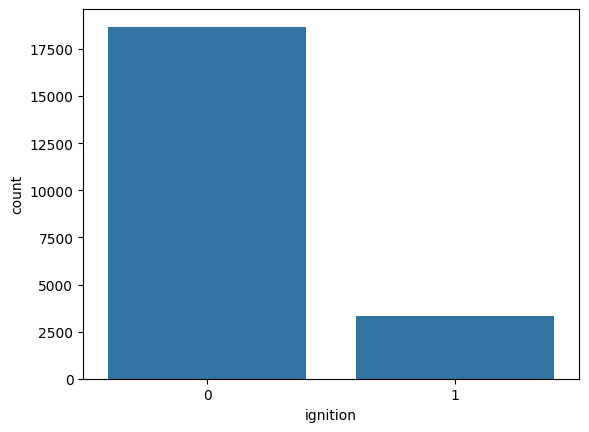

In [28]:
sns.countplot(x='ignition',data=df)

Pour ce problème, on remarque que nous avons une classe déséquilibrée comme le montre la figure précédent. Nous y ferons attentions notamment en utilisant une K-fold stratifiée, qui garantit que chaque fold contient une proportion représentative de chaque classe. La validation croisée sera utilisée car c'est un excellent moyen de faire en sorte que notre modèle soit capable de bien généraliser sur des données qu'il n'a jamais vu.

In [29]:
df.to_csv("data/classification_dataframe/dataset_nettoyer.csv")

### Problème de classification

**Démarche**

Après l'étude exploratoire de nos données, nous avons pris le temps d'analyser et de mieux comprendre nos données. À présent, nous pouvons commencer à mettre en place nos premières étapes de modélisation.  

- Pour assurer une meilleure généralisation des résultats, nous avons choisi d'utiliser la validation croisée avec StratifiedKFold. Il s'agit d'un outil qui est adapté à notre problématique de classification avec des classes déséquilibrées, comme nous l'avons observé. Contrairement à une validation croisée classique, la validation croisée stratifiée permet de garantir une répartition équilibrée des classes dans les différentes fold.

- En complément, nous appliquerons également la méthode classique de GridSearch pour l'optimisation des hyperparamètres de nos modèles. Cela nous permettra de tester plusieurs configurations afin de trouver celle qui maximise les performances.

In [30]:
def seed(seed_value=123):
    """
    Set seed for reproducibility across numpy, tensorflow, and random modules.
    """
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    random.seed(seed_value)


def temps(tps_ecoule, i=None, fin=False, best_acc=None, best_f1=None):
    """
    Format elapsed time and optionally print the final time or model performance.
    """
    hrs = int(tps_ecoule // 3600)
    tps_ecoule -= hrs * 3600
    min = int(tps_ecoule // 60)
    tps_ecoule -= min * 60
    sec = tps_ecoule
    
    # Formatage du temps
    if hrs != 0:
        tps = f"{hrs}h{min}m{int(sec)}s"
    elif min != 0:
        tps = f"{min}m{int(sec)}s"
    else:
        tps = f"{round(sec, 3)}s"
    
    # Affichage du temps et des performances du modèle
    if fin:
        print("Processus terminé : " + tps)
    else:
        print(f"Modèle n°{i + 1} : {tps} | Précision : {round(best_acc * 100, 2)}% | F1 : {round(best_f1, 3)}")

In [31]:
CSV_à_ouvrir = "data/classification_dataframe/dataset_nettoyer.csv"

Colonne_utilisées = [
    'distance_fire_stations', 'distance_rivers', 'distance_roads',
    'distance_powerlines', 'cropland', 'forest_deciduous_broad',
    'forest_deciduous_needle', 'forest_evergreen_broad',
    'forest_evergreen_needle', 'forest_mixed', 'forest_unknown',
    'herbaceous_vegetation', 'moss_lichen', 'shrubland',
    'sprarse_vegetation', 'urban', 'water', 'wetland', 'aspect',
    'elevation', 'pop_dens', 'slope', 'anom_max_temp', 'anom_max_wind_vel',
    'anom_avg_temp', 'anom_avg_rel_hum', 'anom_avg_soil', 'anom_sum_prec',
    'max_temp', 'max_wind_vel', 'avg_temp', 'avg_wind_angle', 'avg_rel_hum',
    'avg_soil', 'sum_prec', 'forest', 'vegetation_class', 'Year',
    'max_max_temp', 'yearly_avg_temp'
]

Colonne_Cible = 'ignition'

Nous testons plusieurs modèles :

- `RandomForest` : C’est un modèle basé sur des arbres de décision. Il est très utile pour capturer des relations complexes entre les variables.  
- `XGBoost` : C’est une version avancée des arbres de décision avec un système de boosting, c’est-à-dire qu’il améliore les prédictions en construisant des modèles successifs qui corrigent les erreurs des précédents.  
- `Réseaux de neurones` : Ces modèles utilisent une où plusieurs couches de neurones entre elles pour capturer les relations non linéaires.  

In [32]:
def import_model(model_name, hyperparams):
    """
    Defines a model based on the provided name and hyperparameters.
    """
    seed()

    if model_name == "rforest":
        # Modèle RandomForest
        mod = RandomForestClassifier(
            n_estimators=int(hyperparams["trees"]), 
            max_depth=int(hyperparams["max_deep"]),
            random_state=123
        )
    elif model_name == "xgboost":
        # Modèle Gradient Boosting
        mod = GradientBoostingClassifier(
            n_estimators=int(hyperparams["trees"]),
            learning_rate=hyperparams["learning_rate"],
            random_state=123
        )
    elif model_name == "ml_dense1":
        # Modèle Réseaux de Neurones à une couche
        mod = Sequential()
        mod.add(InputLayer((len(Colonne_utilisées),))) 
        mod.add(Dense(int(hyperparams["couche1"]), activation='relu'))
        mod.add(Dense(1, activation='sigmoid')) 
        mod.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    elif model_name == "ml_dense2":
        # Modèle Réseaux de Neurones à deux couches
        mod = Sequential()
        mod.add(InputLayer((len(Colonne_utilisées),)))
        mod.add(Dense(int(hyperparams["couche1"]), activation='relu'))
        mod.add(Dense(int(hyperparams["couche2"]), activation='relu'))
        mod.add(Dense(1, activation='sigmoid')) 
        mod.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return mod


Pour chaque modèle, nous avons défini une gridsearch. Ces hyperparamètres sont uniquements les paramètres de bases les plus importantes.

In [33]:
## Plages des hyperparamètres par défaut
Plages = {
    "rforest": {"trees": (5, 200), "max_deep": (1, 20)},
    "xgboost": {"trees": (5, 200), "learning_rate": (0.0001, 1)},
    "ml_dense1": {"couche1": (5, 200)},
    "ml_dense2": {"couche1": (5, 200), "couche2": (5, 200)}
}

## Noms pour les graphiques
Labels = {
    "rforest": ["Random Forest", "trees", "max_deep"], 
    "xgboost": ["XGBoost", "trees", "learning_rate"],
    "ml_dense1": ["mldense1", "couche 1"],            
    "ml_dense2": ["mldense2", "couche 1", "couche 2"], 
} 


Nous évaluons chaque modèle avec deux métriques :

- `La précision` : Il s'agit du pourcentage de prédictions correctes.
- `Le score F1` : Il s'agit d'une mesure plus adaptée dans les cas de déséquilibre de classes, car elle combine la précision et le rappel (la capacité à identifier correctement les ignitions et les non-ignitions).


Dans la suite, nous visualiserons également la matrice de confusion qui est un outil visuel qui permet de mieux comprendre les performances d'un modèle de classification. Elle montre comment le modèle se trompe en montrant les prédictions correctes (vrais positifs et vrais négatifs) ainsi que les erreurs (faux positifs et faux négatifs).

In [34]:
# Meilleur modèle dans notre liste
def find_best_index(vals, objective):
    """
    Finds the index of the best result in the list of values.
    """
    if objective == "max":
        return np.argmax(vals)
    elif objective == "min":
        return np.argmin(vals)
    else:
        raise ValueError("L'objectif doit être 'max' ou 'min'")

# Graphique
def plot_result(vals, ylabel, objective,xticks, labels, model_name, results_dir):
    """
    Plots the metrics based on hyperparameters. 
    Handles cases with one or multiple hyperparameters.
    """
    if not isinstance(xticks[0], list):
        # Un seul hyperparamètre
        fig = go.Figure(data=[go.Scatter(
            x=xticks,
            y=vals,
            mode='markers',
            marker=dict(
                size=5,
                color=vals,
                colorbar=dict(title='Valeurs'),
                colorscale="bluered"
            ),
            name="Résultats modèles"
        )])
        idx = find_best_index(vals, objective)
        fig.add_trace(go.Scatter(
            x=[xticks[idx]],
            y=[vals[idx]],
            mode='markers',
            marker=dict(color='green', size=10),
            name='Meilleure combinaison'
        ))
        fig.update_layout(
            title=labels[model_name][0],
            xaxis_title=labels[model_name][1],
            yaxis_title=ylabel,
            legend=dict(x=0, y=1, traceorder='normal', orientation='h', bgcolor='rgba(0,0,0,0)')
        )
    else:
        # Plusieurs hyperparamètres
        fig = go.Figure(data=[go.Scatter3d(
            x=[coord[0] for coord in xticks],
            y=[coord[1] for coord in xticks],  
            z=vals,
            mode='markers',
            marker=dict(
                size=5,
                color=vals,
                colorbar=dict(title='Valeurs'),
                colorscale="bluered"
            ),
            name="Résultats modèles"
        )])
        idx = find_best_index(vals, objective)
        fig.add_trace(go.Scatter3d(
            x=[xticks[idx][0]],
            y=[xticks[idx][1]],
            z=[vals[idx]],
            mode='markers',
            marker=dict(color='green', size=10),
            name='Meilleure combinaison'
        ))
        fig.update_layout(
            title=labels[model_name][0],
            scene=dict(
                xaxis_title=labels[model_name][1],
                yaxis_title=labels[model_name][2],
                zaxis_title=ylabel,
            ),
            legend=dict(x=0, y=1, traceorder='normal', orientation='h', bgcolor='rgba(0,0,0,0)')
        )
    # Sauvegarde du graphique au format HTML
    fig.write_html(f"{results_dir}/graph_{ylabel}_{model_name}.html")


In [35]:
def optimise_model(
    model_name: str,
    cv: int = 5,
    shuffle: bool = False,
    fichier: str = CSV_à_ouvrir,
    X_col: list = Colonne_utilisées,
    y_col: str = Colonne_Cible,
    Plages: dict = Plages,
    labels: dict = Labels,
    **args
):
    """
    This function optimizes a model by searching for hyperparameters via cross-validation. 
        It also generates performance graphs and calculates feature importances.
    """
    
    # Initialisation pour stocker les variables
    accuracies = []
    f1_scores = []
    times_elapsed = []
    best_acc = [None]
    best_f1 = [None]
    best_y_cv = [None]
    xticks = []
    iteration = [0]

    scaler = StandardScaler()

    data = pd.read_csv(fichier)
    X = data[X_col]
    X = scaler.fit_transform(X)
    y = data[y_col].values.ravel()

    # Définition de la validation croisée
    kf = StratifiedKFold(n_splits=cv, shuffle=shuffle, random_state=1 if shuffle else None)

    param_range = Plages[model_name]

    # Optimisation et évaluation des modèles
    def model_cv(hyperparams):
        start_time = time.time()

        mod = import_model(model_name, hyperparams)
        y_cv_target = y
        y_cv_predictions = np.zeros(len(X))

        for train_index, test_index in tqdm(kf.split(X, y_cv_target), total=kf.get_n_splits(), leave=False):
            X_train, X_test = X[train_index, :], X[test_index, :]
            y_train = y_cv_target[train_index]

            if not model_name.startswith("ml_dense"):
                mod.fit(X_train, y_train)
                y_pred = mod.predict(X_test)
            else:
                mod.fit(X_train, y_train, verbose=0)
                y_pred = mod.predict(X_test, verbose=0)
                y_pred = (y_pred >= 0.5).astype(int).ravel()

            y_cv_predictions[test_index] = y_pred

        # Résultats
        acc = accuracy_score(y_cv_target, y_cv_predictions)
        f1 = f1_score(y_cv_target, y_cv_predictions, average='weighted')
        accuracies.append(acc)
        f1_scores.append(f1)
        times_elapsed.append(round(time.time() - start_time, 4))

        # Update des meilleures performances obtenues
        if best_f1[0] is None or f1 > best_f1[0]:
            best_f1[0], best_y_cv[0] = f1, y_cv_predictions
            best_mod[0] = mod
            best_hyperparams[0] = hyperparams.copy()

        if best_acc[0] is None or acc > best_acc[0]:
            best_acc[0] = acc

        temps(round(time.time() - start_time, 4), i=iteration[0], best_acc=best_acc[0], best_f1=best_f1[0])
        iteration[0] += 1
        xticks.append(list(hyperparams.values()))

    # Initialisation des variables pour stocker le meilleur modèle et les meilleurs hyperparamètres
    best_mod = [None]
    best_hyperparams = [{}]

    total_start_time = time.time()
    print("#######################################\n")

    # Grille pour hyperparamètres
    ticks = []
    grid_values = []
    for param_name, value_range in param_range.items():
        grid_values.append(np.linspace(value_range[0], value_range[1], args["nbr_grid"][param_name], True))
    grid_combinations = list(product(*grid_values))
    for combination in grid_combinations:
        ticks.append({list(param_range.keys())[i]: combination[i] for i in range(len(param_range))})

    # Entraînement et évaluation du modèle
    for hyperparams in ticks:
        model_cv(hyperparams)

    # Affichage du temps total
    print("\n#######################################\n")
    temps(time.time() - total_start_time, fin=True)
    print("\n#######################################\n")

    # Sauvegarde des résultats dans un fichier Excel
    if not isinstance(xticks[0], list):
        df = pd.DataFrame(data={"Paramètre": xticks, "Accuracy": accuracies, "F1": f1_scores, "Temps": times_elapsed})
    else:
        data_dict = {}
        for i in range(len(xticks[0])):
            data_dict.update({"Paramètre " + str(i + 1): [xticks[j][i] for j in range(len(xticks))]})
        data_dict.update({"Accuracy": accuracies, "F1": f1_scores, "Temps": times_elapsed})
        df = pd.DataFrame(data=data_dict)

    results_dir = f'Resultat'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    df.to_excel(f"{results_dir}/Result_{model_name}.xlsx", index=False)

    print(f"Le paramètre optimal est : {best_hyperparams[0]}\nAccuracy : {best_acc[0]:.1%} | F1 : {best_f1[0]:.3f}")
    print("\n#######################################\n")

    # Entrainement finale du meilleur modèle
    best_model = import_model(model_name, best_hyperparams[0])
    best_model.fit(X, y)

    # Changer les probabilités en (0,1)
    y_pred_best = best_model.predict(X)
    y_pred_best = (y_pred_best >= 0.5).astype(int).ravel()

    ## Visualiation graphique
    cm = confusion_matrix(y, y_pred_best)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-ignition', 'Ignition'],
                yticklabels=['Non-ignition', 'Ignition'])
    plt.title(f"Matrice de confusion - Meilleur modèle {model_name}")
    plt.xlabel("Prédiction")
    plt.ylabel("Vrai")
    plt.tight_layout()
    plt.show()
    
    if model_name.startswith("ml_dense"):

        X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)

        @tf.function
        def get_gradients(model, inputs):
            with tf.GradientTape() as tape:
                tape.watch(inputs)
                predictions = model(inputs, training=False)
            gradients = tape.gradient(predictions, inputs)
            return gradients

        gradients = get_gradients(best_model, X_tensor)
        avg_gradients = tf.reduce_mean(gradients, axis=0).numpy()
        gradient_df = pd.DataFrame({
            'Feature': X_col,
            'Average Gradient': avg_gradients
        })
        gradient_df = gradient_df.sort_values(by='Average Gradient', ascending=False)
        plt.figure(figsize=(10, 8))
        plt.barh(gradient_df['Feature'], gradient_df['Average Gradient'])
        plt.gca().invert_yaxis()
        plt.title(f'Gradients moyens pour {labels[model_name][0]}')
        plt.xlabel('Gradient moyen')
        plt.ylabel('Caractéristique')
        plt.tight_layout()
        plt.savefig(f"{results_dir}/Gradients_{model_name}.png")
        plt.close()

    else:
        plot_result(f1_scores, 'F1 Score', 'max', xticks, labels, model_name, results_dir)
        plot_result(accuracies, 'Accuracy', 'max', xticks, labels, model_name, results_dir)

        feature_importances = best_model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': X_col,
            'Importance': feature_importances
        })
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        plt.figure(figsize=(10, 8))
        plt.barh(importance_df['Feature'], importance_df['Importance'])
        plt.gca().invert_yaxis()
        plt.title(f'Importances des caractéristiques pour {labels[model_name][0]}')
        plt.xlabel('Importance')
        plt.ylabel('Caractéristique')
        plt.tight_layout()
        plt.savefig(f"{results_dir}/Importances_{model_name}.png")
        plt.close()
 


#######################################



Modèle n°1 : 0.204s | Précision : 84.91% | F1 : 0.78


Modèle n°2 : 0.276s | Précision : 85.58% | F1 : 0.8


Modèle n°3 : 0.344s | Précision : 87.47% | F1 : 0.847


Modèle n°4 : 0.446s | Précision : 87.94% | F1 : 0.861


Modèle n°5 : 0.552s | Précision : 88.19% | F1 : 0.868


Modèle n°6 : 0.646s | Précision : 88.19% | F1 : 0.87


Modèle n°7 : 0.687s | Précision : 88.19% | F1 : 0.87


Modèle n°8 : 0.715s | Précision : 88.19% | F1 : 0.873


Modèle n°9 : 0.73s | Précision : 88.19% | F1 : 0.874


Modèle n°10 : 0.733s | Précision : 88.19% | F1 : 0.874


Modèle n°11 : 0.452s | Précision : 88.19% | F1 : 0.874


Modèle n°12 : 1.024s | Précision : 88.19% | F1 : 0.874


Modèle n°13 : 1.615s | Précision : 88.19% | F1 : 0.874


Modèle n°14 : 2.166s | Précision : 88.23% | F1 : 0.874


Modèle n°15 : 2.685s | Précision : 88.72% | F1 : 0.874


Modèle n°16 : 3.057s | Précision : 89.13% | F1 : 0.878


Modèle n°17 : 3.33s | Précision : 89.44% | F1 : 0.883


Modèle n°18 : 3.509s | Précision : 89.5% | F1 : 0.885


Modèle n°19 : 3.627s | Précision : 89.61% | F1 : 0.886


Modèle n°20 : 3.665s | Précision : 89.61% | F1 : 0.886


Modèle n°21 : 0.818s | Précision : 89.61% | F1 : 0.886


Modèle n°22 : 1.895s | Précision : 89.61% | F1 : 0.886


Modèle n°23 : 3.005s | Précision : 89.61% | F1 : 0.886


Modèle n°24 : 4.031s | Précision : 89.61% | F1 : 0.886


Modèle n°25 : 4.957s | Précision : 89.61% | F1 : 0.886


Modèle n°26 : 5.626s | Précision : 89.61% | F1 : 0.886


Modèle n°27 : 6.147s | Précision : 89.66% | F1 : 0.886


Modèle n°28 : 6.463s | Précision : 89.66% | F1 : 0.886


Modèle n°29 : 6.692s | Précision : 89.9% | F1 : 0.889


Modèle n°30 : 6.805s | Précision : 89.9% | F1 : 0.889


Modèle n°31 : 1.171s | Précision : 89.9% | F1 : 0.889


Modèle n°32 : 2.754s | Précision : 89.9% | F1 : 0.889


Modèle n°33 : 4.359s | Précision : 89.9% | F1 : 0.889


Modèle n°34 : 5.863s | Précision : 89.9% | F1 : 0.889


Modèle n°35 : 7.181s | Précision : 89.9% | F1 : 0.889


Modèle n°36 : 8.178s | Précision : 89.9% | F1 : 0.889


Modèle n°37 : 8.962s | Précision : 89.9% | F1 : 0.889


Modèle n°38 : 9.428s | Précision : 89.9% | F1 : 0.889


Modèle n°39 : 9.733s | Précision : 90.0% | F1 : 0.89


Modèle n°40 : 9.868s | Précision : 90.0% | F1 : 0.89


Modèle n°41 : 1.543s | Précision : 90.0% | F1 : 0.89


Modèle n°42 : 3.607s | Précision : 90.0% | F1 : 0.89


Modèle n°43 : 5.671s | Précision : 90.0% | F1 : 0.89


Modèle n°44 : 7.679s | Précision : 90.0% | F1 : 0.89


Modèle n°45 : 9.342s | Précision : 90.0% | F1 : 0.89


Modèle n°46 : 10.697s | Précision : 90.0% | F1 : 0.89


Modèle n°47 : 11.744s | Précision : 90.0% | F1 : 0.89


Modèle n°48 : 12.456s | Précision : 90.0% | F1 : 0.89


Modèle n°49 : 12.621s | Précision : 90.1% | F1 : 0.891


Modèle n°50 : 12.815s | Précision : 90.1% | F1 : 0.891


Modèle n°51 : 1.885s | Précision : 90.1% | F1 : 0.891


Modèle n°52 : 4.455s | Précision : 90.1% | F1 : 0.891


Modèle n°53 : 7.032s | Précision : 90.1% | F1 : 0.891


Modèle n°54 : 9.481s | Précision : 90.1% | F1 : 0.891


Modèle n°55 : 11.558s | Précision : 90.1% | F1 : 0.891


Modèle n°56 : 13.211s | Précision : 90.1% | F1 : 0.891


Modèle n°57 : 14.494s | Précision : 90.1% | F1 : 0.891


Modèle n°58 : 15.185s | Précision : 90.1% | F1 : 0.891


Modèle n°59 : 15.669s | Précision : 90.1% | F1 : 0.891


Modèle n°60 : 15.977s | Précision : 90.1% | F1 : 0.891


Modèle n°61 : 2.237s | Précision : 90.1% | F1 : 0.891


Modèle n°62 : 5.32s | Précision : 90.1% | F1 : 0.891


Modèle n°63 : 8.412s | Précision : 90.1% | F1 : 0.891


Modèle n°64 : 11.381s | Précision : 90.1% | F1 : 0.891


Modèle n°65 : 13.807s | Précision : 90.1% | F1 : 0.891


Modèle n°66 : 15.789s | Précision : 90.1% | F1 : 0.891


Modèle n°67 : 17.278s | Précision : 90.1% | F1 : 0.891


Modèle n°68 : 18.135s | Précision : 90.1% | F1 : 0.891


Modèle n°69 : 18.754s | Précision : 90.11% | F1 : 0.891


Modèle n°70 : 19.109s | Précision : 90.11% | F1 : 0.891


Modèle n°71 : 2.584s | Précision : 90.11% | F1 : 0.891


Modèle n°72 : 6.183s | Précision : 90.11% | F1 : 0.891


Modèle n°73 : 9.752s | Précision : 90.11% | F1 : 0.891


Modèle n°74 : 13.198s | Précision : 90.11% | F1 : 0.891


Modèle n°75 : 16.024s | Précision : 90.11% | F1 : 0.891


Modèle n°76 : 18.398s | Précision : 90.11% | F1 : 0.891


Modèle n°77 : 20.057s | Précision : 90.11% | F1 : 0.891


Modèle n°78 : 21.058s | Précision : 90.11% | F1 : 0.891


Modèle n°79 : 21.661s | Précision : 90.11% | F1 : 0.891


Modèle n°80 : 21.959s | Précision : 90.11% | F1 : 0.891


Modèle n°81 : 2.953s | Précision : 90.11% | F1 : 0.891


Modèle n°82 : 7.081s | Précision : 90.11% | F1 : 0.891


Modèle n°83 : 11.269s | Précision : 90.11% | F1 : 0.891


Modèle n°84 : 15.086s | Précision : 90.11% | F1 : 0.891


Modèle n°85 : 18.388s | Précision : 90.11% | F1 : 0.891


Modèle n°86 : 20.888s | Précision : 90.11% | F1 : 0.891


Modèle n°87 : 22.802s | Précision : 90.11% | F1 : 0.891


Modèle n°88 : 23.94s | Précision : 90.11% | F1 : 0.891


Modèle n°89 : 24.833s | Précision : 90.11% | F1 : 0.891


Modèle n°90 : 25.203s | Précision : 90.11% | F1 : 0.891


Modèle n°91 : 3.317s | Précision : 90.11% | F1 : 0.891


Modèle n°92 : 7.932s | Précision : 90.11% | F1 : 0.891


Modèle n°93 : 12.508s | Précision : 90.11% | F1 : 0.891


Modèle n°94 : 16.933s | Précision : 90.11% | F1 : 0.891


Modèle n°95 : 20.681s | Précision : 90.11% | F1 : 0.891


Modèle n°96 : 23.499s | Précision : 90.11% | F1 : 0.891


Modèle n°97 : 25.772s | Précision : 90.11% | F1 : 0.891


Modèle n°98 : 27.071s | Précision : 90.11% | F1 : 0.891


Modèle n°99 : 27.956s | Précision : 90.11% | F1 : 0.891


Modèle n°100 : 28.426s | Précision : 90.13% | F1 : 0.891

#######################################

Processus terminé : 16m29s

#######################################

Le paramètre optimal est : {'trees': 200.0, 'max_deep': 20.0}
Accuracy : 90.1% | F1 : 0.891

#######################################



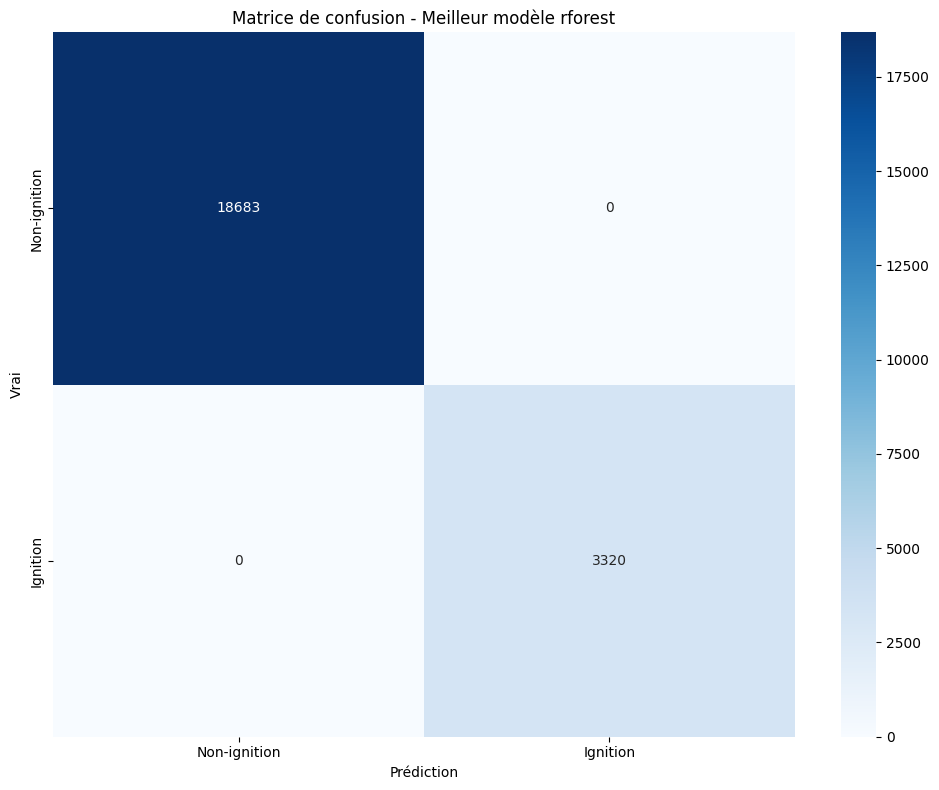

In [36]:
optimise_model(
    model_name='rforest',
    nbr_grid={'trees': 10, 'max_deep': 10},
    cv=5,
    shuffle=True
)

Après l'utilisation de la validation croisée nous obtenons une précision de 90.1% et un score-F1 de 0.891. En réentrainant le meilleur modèle sur l'ensemble des données montre une excellente performance de classification comme on le remarque avec la matrice de confusion, il a correctement identifié les cas non-ignitions et ignitions, avec aucun faux négatif et aucun faux positif. 

On peut en conclure que ce modèle semble globalement performant, afin de pouvoir mieux vérifier ces performances, il aurait fallu diviser le dataset avec un jeu de validation afin de tester ces performances réelles sur des données qu'il n'avait jamais vu.

#######################################



Modèle n°1 : 1.692s | Précision : 84.91% | F1 : 0.78


Modèle n°2 : 1.632s | Précision : 84.91% | F1 : 0.78


Modèle n°3 : 1.627s | Précision : 87.22% | F1 : 0.84


Modèle n°4 : 1.631s | Précision : 87.78% | F1 : 0.857


Modèle n°5 : 1.631s | Précision : 87.96% | F1 : 0.863


Modèle n°6 : 1.626s | Précision : 87.96% | F1 : 0.863


Modèle n°7 : 1.636s | Précision : 87.96% | F1 : 0.868


Modèle n°8 : 1.628s | Précision : 87.96% | F1 : 0.869


Modèle n°9 : 1.62s | Précision : 87.96% | F1 : 0.869


Modèle n°10 : 1.633s | Précision : 87.96% | F1 : 0.869


Modèle n°11 : 8.27s | Précision : 87.96% | F1 : 0.869


Modèle n°12 : 8.247s | Précision : 88.37% | F1 : 0.869


Modèle n°13 : 8.213s | Précision : 88.61% | F1 : 0.876


Modèle n°14 : 8.195s | Précision : 88.73% | F1 : 0.879


Modèle n°15 : 8.179s | Précision : 88.75% | F1 : 0.879


Modèle n°16 : 8.167s | Précision : 88.75% | F1 : 0.879


Modèle n°17 : 8.168s | Précision : 88.75% | F1 : 0.879


Modèle n°18 : 8.172s | Précision : 88.75% | F1 : 0.879


Modèle n°19 : 8.192s | Précision : 88.75% | F1 : 0.88


Modèle n°20 : 8.18s | Précision : 88.75% | F1 : 0.88


Modèle n°21 : 15.188s | Précision : 88.75% | F1 : 0.88


Modèle n°22 : 15.133s | Précision : 88.75% | F1 : 0.88


Modèle n°23 : 15.033s | Précision : 88.82% | F1 : 0.88


Modèle n°24 : 15.025s | Précision : 89.0% | F1 : 0.883


Modèle n°25 : 15.037s | Précision : 89.06% | F1 : 0.883


Modèle n°26 : 15.02s | Précision : 89.06% | F1 : 0.883


Modèle n°27 : 15.009s | Précision : 89.06% | F1 : 0.883


Modèle n°28 : 15.017s | Précision : 89.06% | F1 : 0.883


Modèle n°29 : 15.003s | Précision : 89.06% | F1 : 0.883


Modèle n°30 : 15.006s | Précision : 89.06% | F1 : 0.883


Modèle n°31 : 22.08s | Précision : 89.06% | F1 : 0.883


Modèle n°32 : 21.983s | Précision : 89.06% | F1 : 0.883


Modèle n°33 : 21.9s | Précision : 89.06% | F1 : 0.883


Modèle n°34 : 21.914s | Précision : 89.12% | F1 : 0.884


Modèle n°35 : 21.918s | Précision : 89.17% | F1 : 0.885


Modèle n°36 : 21.859s | Précision : 89.17% | F1 : 0.885


Modèle n°37 : 21.885s | Précision : 89.17% | F1 : 0.885


Modèle n°38 : 21.901s | Précision : 89.17% | F1 : 0.885


Modèle n°39 : 21.867s | Précision : 89.17% | F1 : 0.885


Modèle n°40 : 21.89s | Précision : 89.17% | F1 : 0.885


Modèle n°41 : 29.257s | Précision : 89.17% | F1 : 0.885


Modèle n°42 : 28.782s | Précision : 89.17% | F1 : 0.885


Modèle n°43 : 28.763s | Précision : 89.17% | F1 : 0.885


Modèle n°44 : 28.713s | Précision : 89.17% | F1 : 0.885


Modèle n°45 : 28.75s | Précision : 89.17% | F1 : 0.885


Modèle n°46 : 28.774s | Précision : 89.17% | F1 : 0.885


Modèle n°47 : 28.633s | Précision : 89.17% | F1 : 0.885


Modèle n°48 : 28.9s | Précision : 89.17% | F1 : 0.885


Modèle n°49 : 28.763s | Précision : 89.17% | F1 : 0.885


Modèle n°50 : 28.758s | Précision : 89.17% | F1 : 0.885


Modèle n°51 : 36.039s | Précision : 89.17% | F1 : 0.885


Modèle n°52 : 35.91s | Précision : 89.17% | F1 : 0.885


Modèle n°53 : 35.454s | Précision : 89.21% | F1 : 0.885


Modèle n°54 : 35.474s | Précision : 89.21% | F1 : 0.885


Modèle n°55 : 35.721s | Précision : 89.21% | F1 : 0.885


Modèle n°56 : 35.498s | Précision : 89.21% | F1 : 0.885


Modèle n°57 : 35.5s | Précision : 89.21% | F1 : 0.885


Modèle n°58 : 35.649s | Précision : 89.21% | F1 : 0.885


Modèle n°59 : 35.407s | Précision : 89.21% | F1 : 0.885


Modèle n°60 : 35.529s | Précision : 89.21% | F1 : 0.885


Modèle n°61 : 42.912s | Précision : 89.21% | F1 : 0.885


Modèle n°62 : 42.942s | Précision : 89.21% | F1 : 0.885


Modèle n°63 : 42.725s | Précision : 89.36% | F1 : 0.887


Modèle n°64 : 42.539s | Précision : 89.36% | F1 : 0.887


Modèle n°65 : 42.349s | Précision : 89.36% | F1 : 0.887


Modèle n°66 : 42.423s | Précision : 89.36% | F1 : 0.887


Modèle n°67 : 42.49s | Précision : 89.36% | F1 : 0.887


Modèle n°68 : 42.363s | Précision : 89.36% | F1 : 0.887


Modèle n°69 : 42.309s | Précision : 89.36% | F1 : 0.887


Modèle n°70 : 42.105s | Précision : 89.36% | F1 : 0.887


Modèle n°71 : 49.688s | Précision : 89.36% | F1 : 0.887


Modèle n°72 : 48.927s | Précision : 89.36% | F1 : 0.887


Modèle n°73 : 48.826s | Précision : 89.36% | F1 : 0.887


Modèle n°74 : 49.121s | Précision : 89.41% | F1 : 0.888


Modèle n°75 : 48.982s | Précision : 89.41% | F1 : 0.888


Modèle n°76 : 48.844s | Précision : 89.41% | F1 : 0.888


Modèle n°77 : 48.782s | Précision : 89.41% | F1 : 0.888


Modèle n°78 : 48.711s | Précision : 89.41% | F1 : 0.888


Modèle n°79 : 48.703s | Précision : 89.41% | F1 : 0.888


Modèle n°80 : 48.711s | Précision : 89.41% | F1 : 0.888


Modèle n°81 : 56.15s | Précision : 89.41% | F1 : 0.888


Modèle n°82 : 55.552s | Précision : 89.41% | F1 : 0.888


Modèle n°83 : 55.514s | Précision : 89.41% | F1 : 0.888


Modèle n°84 : 55.511s | Précision : 89.41% | F1 : 0.888


Modèle n°85 : 55.513s | Précision : 89.41% | F1 : 0.888


Modèle n°86 : 55.492s | Précision : 89.41% | F1 : 0.888


Modèle n°87 : 55.516s | Précision : 89.41% | F1 : 0.888


Modèle n°88 : 55.547s | Précision : 89.41% | F1 : 0.888


Modèle n°89 : 55.487s | Précision : 89.41% | F1 : 0.888


Modèle n°90 : 56.154s | Précision : 89.41% | F1 : 0.888


Modèle n°91 : 1m3s | Précision : 89.41% | F1 : 0.888


Modèle n°92 : 1m3s | Précision : 89.41% | F1 : 0.888


Modèle n°93 : 1m3s | Précision : 89.41% | F1 : 0.888


Modèle n°94 : 1m2s | Précision : 89.41% | F1 : 0.888


Modèle n°95 : 1m3s | Précision : 89.41% | F1 : 0.888


Modèle n°96 : 1m2s | Précision : 89.41% | F1 : 0.888


Modèle n°97 : 1m3s | Précision : 89.41% | F1 : 0.888


Modèle n°98 : 1m3s | Précision : 89.41% | F1 : 0.888


Modèle n°99 : 1m3s | Précision : 89.41% | F1 : 0.888


Modèle n°100 : 1m2s | Précision : 89.41% | F1 : 0.888

#######################################

Processus terminé : 53m35s

#######################################

Le paramètre optimal est : {'trees': 200.0, 'learning_rate': 0.33340000000000003}
Accuracy : 89.4% | F1 : 0.888

#######################################



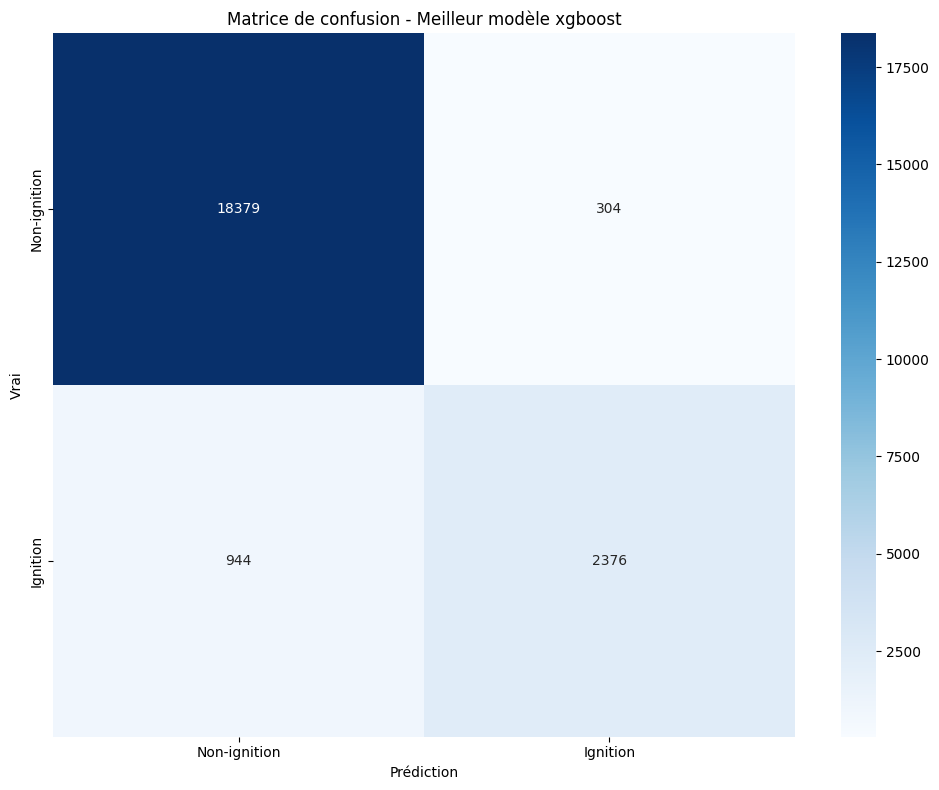

In [45]:
optimise_model(
    model_name='xgboost',
    nbr_grid={'trees': 10, 'learning_rate': 10},
    cv=5,
    shuffle=True
)

On remarque que le modèle XGBoost présente de très bonnes performances après réentraînement du modèle. Il est très légèrement moins précis que le RandomForest, avec un taux de précision de 89.4% et un F1-score de 0.888. 

#######################################



Modèle n°1 : 1.879s | Précision : 86.38% | F1 : 0.85


Modèle n°2 : 1.79s | Précision : 86.9% | F1 : 0.854


Modèle n°3 : 1.795s | Précision : 86.9% | F1 : 0.854


Modèle n°4 : 1.814s | Précision : 87.09% | F1 : 0.858


Modèle n°5 : 1.802s | Précision : 87.09% | F1 : 0.858


Modèle n°6 : 1.81s | Précision : 87.17% | F1 : 0.858


Modèle n°7 : 1.785s | Précision : 87.29% | F1 : 0.861


Modèle n°8 : 1.792s | Précision : 87.29% | F1 : 0.861


Modèle n°9 : 1.798s | Précision : 87.29% | F1 : 0.861


Modèle n°10 : 1.785s | Précision : 87.47% | F1 : 0.861


Modèle n°11 : 1.768s | Précision : 87.47% | F1 : 0.861


Modèle n°12 : 1.798s | Précision : 87.47% | F1 : 0.861


Modèle n°13 : 1.794s | Précision : 87.47% | F1 : 0.861


Modèle n°14 : 2.165s | Précision : 87.47% | F1 : 0.861


Modèle n°15 : 1.785s | Précision : 87.51% | F1 : 0.862


Modèle n°16 : 1.784s | Précision : 87.51% | F1 : 0.862


Modèle n°17 : 1.808s | Précision : 87.55% | F1 : 0.862


Modèle n°18 : 1.801s | Précision : 87.55% | F1 : 0.862


Modèle n°19 : 1.804s | Précision : 87.55% | F1 : 0.862


Modèle n°20 : 1.785s | Précision : 87.62% | F1 : 0.864


Modèle n°21 : 1.777s | Précision : 87.62% | F1 : 0.864


Modèle n°22 : 1.784s | Précision : 87.62% | F1 : 0.864


Modèle n°23 : 1.769s | Précision : 87.62% | F1 : 0.864


Modèle n°24 : 1.805s | Précision : 87.62% | F1 : 0.864


Modèle n°25 : 1.8s | Précision : 87.62% | F1 : 0.864


Modèle n°26 : 1.802s | Précision : 87.67% | F1 : 0.864


Modèle n°27 : 1.81s | Précision : 87.67% | F1 : 0.864


Modèle n°28 : 1.808s | Précision : 87.67% | F1 : 0.864


Modèle n°29 : 1.818s | Précision : 87.67% | F1 : 0.864


Modèle n°30 : 1.798s | Précision : 87.67% | F1 : 0.864


Modèle n°31 : 1.818s | Précision : 87.67% | F1 : 0.864


Modèle n°32 : 2.197s | Précision : 87.67% | F1 : 0.864


Modèle n°33 : 1.847s | Précision : 87.85% | F1 : 0.865


Modèle n°34 : 1.815s | Précision : 87.85% | F1 : 0.865


Modèle n°35 : 1.824s | Précision : 87.85% | F1 : 0.865


Modèle n°36 : 1.848s | Précision : 87.85% | F1 : 0.865


Modèle n°37 : 1.833s | Précision : 87.85% | F1 : 0.865


Modèle n°38 : 1.843s | Précision : 87.85% | F1 : 0.865


Modèle n°39 : 1.833s | Précision : 87.85% | F1 : 0.865


Modèle n°40 : 1.822s | Précision : 87.85% | F1 : 0.865


Modèle n°41 : 1.839s | Précision : 87.88% | F1 : 0.866


Modèle n°42 : 1.839s | Précision : 87.88% | F1 : 0.866


Modèle n°43 : 1.846s | Précision : 87.88% | F1 : 0.866


Modèle n°44 : 1.836s | Précision : 87.88% | F1 : 0.866


Modèle n°45 : 1.85s | Précision : 87.88% | F1 : 0.866


Modèle n°46 : 1.827s | Précision : 87.88% | F1 : 0.866


Modèle n°47 : 1.835s | Précision : 87.88% | F1 : 0.866


Modèle n°48 : 1.841s | Précision : 87.88% | F1 : 0.867


Modèle n°49 : 1.845s | Précision : 87.88% | F1 : 0.867


Modèle n°50 : 1.851s | Précision : 87.88% | F1 : 0.867


Modèle n°51 : 1.851s | Précision : 87.88% | F1 : 0.867


Modèle n°52 : 1.86s | Précision : 87.88% | F1 : 0.867


Modèle n°53 : 2.306s | Précision : 87.88% | F1 : 0.867


Modèle n°54 : 1.861s | Précision : 87.88% | F1 : 0.867


Modèle n°55 : 1.87s | Précision : 87.88% | F1 : 0.867


Modèle n°56 : 1.87s | Précision : 87.9% | F1 : 0.867


Modèle n°57 : 1.887s | Précision : 87.95% | F1 : 0.867


Modèle n°58 : 1.868s | Précision : 87.95% | F1 : 0.867


Modèle n°59 : 1.865s | Précision : 87.95% | F1 : 0.867


Modèle n°60 : 1.86s | Précision : 87.95% | F1 : 0.867


Modèle n°61 : 1.848s | Précision : 87.95% | F1 : 0.867


Modèle n°62 : 1.854s | Précision : 87.95% | F1 : 0.867


Modèle n°63 : 1.863s | Précision : 87.95% | F1 : 0.867


Modèle n°64 : 1.82s | Précision : 87.95% | F1 : 0.867


Modèle n°65 : 1.86s | Précision : 87.95% | F1 : 0.867


Modèle n°66 : 1.862s | Précision : 87.95% | F1 : 0.867


Modèle n°67 : 1.837s | Précision : 87.95% | F1 : 0.867


Modèle n°68 : 1.87s | Précision : 87.95% | F1 : 0.867


Modèle n°69 : 1.862s | Précision : 87.96% | F1 : 0.867


Modèle n°70 : 1.842s | Précision : 87.96% | F1 : 0.867


Modèle n°71 : 1.857s | Précision : 87.96% | F1 : 0.867


Modèle n°72 : 1.857s | Précision : 87.96% | F1 : 0.867


Modèle n°73 : 1.86s | Précision : 87.96% | F1 : 0.867


Modèle n°74 : 1.848s | Précision : 87.96% | F1 : 0.867


Modèle n°75 : 1.843s | Précision : 87.96% | F1 : 0.867


Modèle n°76 : 1.835s | Précision : 87.96% | F1 : 0.867


Modèle n°77 : 1.837s | Précision : 87.96% | F1 : 0.867


Modèle n°78 : 2.379s | Précision : 87.99% | F1 : 0.868


Modèle n°79 : 1.903s | Précision : 87.99% | F1 : 0.868


Modèle n°80 : 1.899s | Précision : 87.99% | F1 : 0.868


Modèle n°81 : 1.909s | Précision : 87.99% | F1 : 0.868


Modèle n°82 : 1.91s | Précision : 87.99% | F1 : 0.868


Modèle n°83 : 1.858s | Précision : 87.99% | F1 : 0.868


Modèle n°84 : 1.851s | Précision : 87.99% | F1 : 0.868


Modèle n°85 : 1.825s | Précision : 87.99% | F1 : 0.868


Modèle n°86 : 1.842s | Précision : 87.99% | F1 : 0.868


Modèle n°87 : 1.836s | Précision : 87.99% | F1 : 0.868


Modèle n°88 : 1.853s | Précision : 87.99% | F1 : 0.868


Modèle n°89 : 1.822s | Précision : 87.99% | F1 : 0.868


Modèle n°90 : 1.803s | Précision : 87.99% | F1 : 0.868


Modèle n°91 : 1.854s | Précision : 87.99% | F1 : 0.868


Modèle n°92 : 1.845s | Précision : 87.99% | F1 : 0.868


Modèle n°93 : 1.838s | Précision : 87.99% | F1 : 0.868


Modèle n°94 : 1.819s | Précision : 88.01% | F1 : 0.868


Modèle n°95 : 1.8s | Précision : 88.01% | F1 : 0.868


Modèle n°96 : 1.841s | Précision : 88.01% | F1 : 0.868


Modèle n°97 : 1.837s | Précision : 88.03% | F1 : 0.869


Modèle n°98 : 1.828s | Précision : 88.03% | F1 : 0.869


Modèle n°99 : 1.817s | Précision : 88.03% | F1 : 0.869


Modèle n°100 : 1.84s | Précision : 88.03% | F1 : 0.869

#######################################

Fin : 3m4s

#######################################

Le paramètre optimal est : {'couche1': 194.0909090909091}
Accuracy : 88.0% | F1 : 0.869

#######################################

688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 377us/step - accuracy: 0.8409 - loss: 0.3310
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step


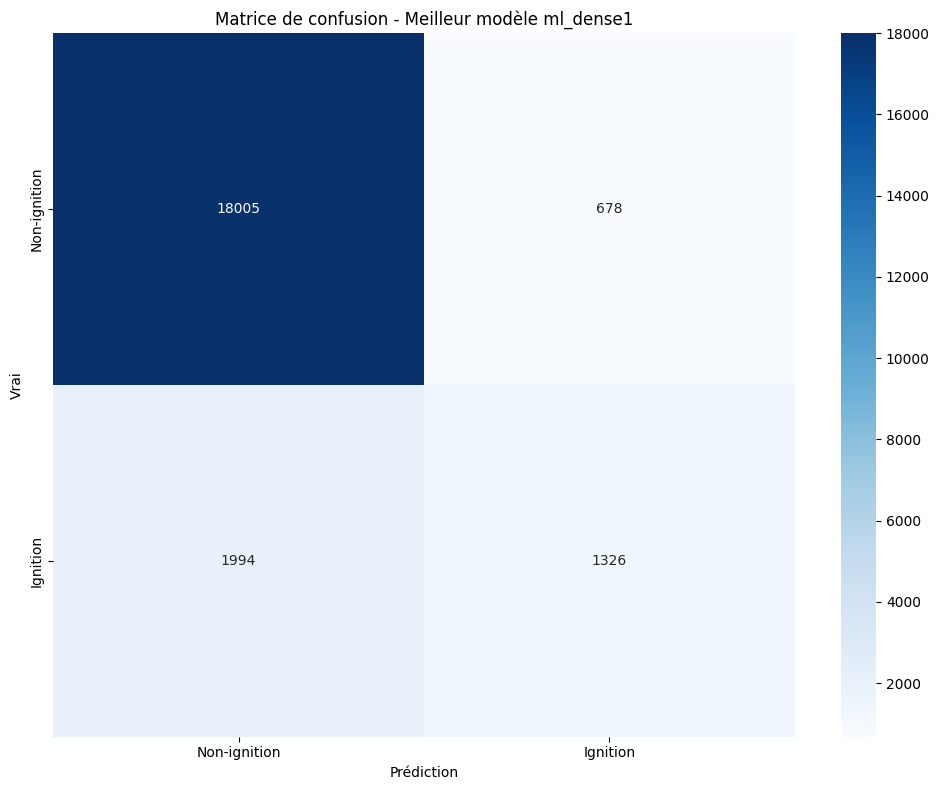

In [38]:
# Plages['ml_dense1'] = {"couche1": (5, 200)}

optimise_model(
    model_name='ml_dense1',
    nbr_grid={'couche1': 100},
    cv=5,
    shuffle=True
)

Le réseau de neurones avec une seule couche dense montre une précision plus faible par rapport aux modèles de RandomForest et de Gradient Boosting, avec 88% de précision et un F1-score de 0.869. 
Ce taux élevé de faux négatifs indique que ce modèle a des difficultés à capturer correctement les ignitions, ce qui est une limitation importante pour cette tâche. 

Ce modèle est moins robustes que les faux précédents d'un facteur 2 dans ces classifications.

#######################################



Modèle n°1 : 2.106s | Précision : 86.4% | F1 : 0.849


Modèle n°2 : 2.059s | Précision : 86.4% | F1 : 0.849


Modèle n°3 : 2.024s | Précision : 86.47% | F1 : 0.849


Modèle n°4 : 1.983s | Précision : 86.47% | F1 : 0.849


Modèle n°5 : 2.014s | Précision : 86.77% | F1 : 0.849


Modèle n°6 : 2.015s | Précision : 86.77% | F1 : 0.849


Modèle n°7 : 2.033s | Précision : 86.77% | F1 : 0.849


Modèle n°8 : 2.565s | Précision : 86.77% | F1 : 0.849


Modèle n°9 : 2.066s | Précision : 86.77% | F1 : 0.849


Modèle n°10 : 2.066s | Précision : 86.77% | F1 : 0.85


Modèle n°11 : 2.01s | Précision : 87.07% | F1 : 0.859


Modèle n°12 : 1.996s | Précision : 87.61% | F1 : 0.863


Modèle n°13 : 2.032s | Précision : 87.61% | F1 : 0.863


Modèle n°14 : 2.033s | Précision : 87.61% | F1 : 0.863


Modèle n°15 : 2.031s | Précision : 87.61% | F1 : 0.863


Modèle n°16 : 2.042s | Précision : 87.68% | F1 : 0.865


Modèle n°17 : 2.046s | Précision : 87.77% | F1 : 0.865


Modèle n°18 : 2.043s | Précision : 87.77% | F1 : 0.865


Modèle n°19 : 2.048s | Précision : 87.77% | F1 : 0.867


Modèle n°20 : 2.048s | Précision : 87.77% | F1 : 0.867


Modèle n°21 : 1.95s | Précision : 87.77% | F1 : 0.867


Modèle n°22 : 2.012s | Précision : 87.87% | F1 : 0.867


Modèle n°23 : 2.012s | Précision : 88.0% | F1 : 0.868


Modèle n°24 : 2.034s | Précision : 88.0% | F1 : 0.868


Modèle n°25 : 2.046s | Précision : 88.05% | F1 : 0.869


Modèle n°26 : 2.045s | Précision : 88.05% | F1 : 0.869


Modèle n°27 : 2.055s | Précision : 88.05% | F1 : 0.869


Modèle n°28 : 2.069s | Précision : 88.08% | F1 : 0.871


Modèle n°29 : 2.083s | Précision : 88.08% | F1 : 0.871


Modèle n°30 : 2.752s | Précision : 88.08% | F1 : 0.871


Modèle n°31 : 2.06s | Précision : 88.08% | F1 : 0.871


Modèle n°32 : 2.065s | Précision : 88.08% | F1 : 0.871


Modèle n°33 : 2.08s | Précision : 88.08% | F1 : 0.871


Modèle n°34 : 2.093s | Précision : 88.08% | F1 : 0.871


Modèle n°35 : 2.07s | Précision : 88.08% | F1 : 0.871


Modèle n°36 : 2.08s | Précision : 88.08% | F1 : 0.871


Modèle n°37 : 2.095s | Précision : 88.1% | F1 : 0.873


Modèle n°38 : 2.083s | Précision : 88.1% | F1 : 0.873


Modèle n°39 : 2.106s | Précision : 88.1% | F1 : 0.873


Modèle n°40 : 2.113s | Précision : 88.1% | F1 : 0.873


Modèle n°41 : 1.974s | Précision : 88.1% | F1 : 0.873


Modèle n°42 : 2.011s | Précision : 88.1% | F1 : 0.873


Modèle n°43 : 2.035s | Précision : 88.24% | F1 : 0.873


Modèle n°44 : 2.06s | Précision : 88.24% | F1 : 0.873


Modèle n°45 : 2.052s | Précision : 88.24% | F1 : 0.874


Modèle n°46 : 2.085s | Précision : 88.24% | F1 : 0.874


Modèle n°47 : 2.078s | Précision : 88.24% | F1 : 0.874


Modèle n°48 : 2.082s | Précision : 88.27% | F1 : 0.874


Modèle n°49 : 2.097s | Précision : 88.27% | F1 : 0.874


Modèle n°50 : 2.124s | Précision : 88.27% | F1 : 0.874


Modèle n°51 : 2.024s | Précision : 88.27% | F1 : 0.874


Modèle n°52 : 2.022s | Précision : 88.27% | F1 : 0.874


Modèle n°53 : 2.055s | Précision : 88.27% | F1 : 0.874


Modèle n°54 : 2.062s | Précision : 88.27% | F1 : 0.874


Modèle n°55 : 2.076s | Précision : 88.27% | F1 : 0.874


Modèle n°56 : 2.889s | Précision : 88.39% | F1 : 0.877


Modèle n°57 : 2.176s | Précision : 88.39% | F1 : 0.877


Modèle n°58 : 2.184s | Précision : 88.39% | F1 : 0.877


Modèle n°59 : 2.257s | Précision : 88.39% | F1 : 0.877


Modèle n°60 : 2.213s | Précision : 88.39% | F1 : 0.877


Modèle n°61 : 2.034s | Précision : 88.39% | F1 : 0.877


Modèle n°62 : 2.067s | Précision : 88.39% | F1 : 0.877


Modèle n°63 : 2.079s | Précision : 88.39% | F1 : 0.877


Modèle n°64 : 2.097s | Précision : 88.39% | F1 : 0.877


Modèle n°65 : 2.086s | Précision : 88.39% | F1 : 0.877


Modèle n°66 : 2.11s | Précision : 88.39% | F1 : 0.877


Modèle n°67 : 2.112s | Précision : 88.39% | F1 : 0.877


Modèle n°68 : 2.127s | Précision : 88.39% | F1 : 0.877


Modèle n°69 : 2.152s | Précision : 88.39% | F1 : 0.877


Modèle n°70 : 2.163s | Précision : 88.39% | F1 : 0.877


Modèle n°71 : 2.041s | Précision : 88.39% | F1 : 0.877


Modèle n°72 : 2.038s | Précision : 88.39% | F1 : 0.877


Modèle n°73 : 2.055s | Précision : 88.39% | F1 : 0.877


Modèle n°74 : 2.1s | Précision : 88.39% | F1 : 0.877


Modèle n°75 : 2.116s | Précision : 88.39% | F1 : 0.877


Modèle n°76 : 2.111s | Précision : 88.39% | F1 : 0.877


Modèle n°77 : 2.134s | Précision : 88.39% | F1 : 0.877


Modèle n°78 : 2.171s | Précision : 88.39% | F1 : 0.877


Modèle n°79 : 2.172s | Précision : 88.46% | F1 : 0.878


Modèle n°80 : 2.185s | Précision : 88.46% | F1 : 0.878


Modèle n°81 : 1.998s | Précision : 88.46% | F1 : 0.878


Modèle n°82 : 2.047s | Précision : 88.46% | F1 : 0.878


Modèle n°83 : 2.077s | Précision : 88.46% | F1 : 0.878


Modèle n°84 : 2.112s | Précision : 88.46% | F1 : 0.878


Modèle n°85 : 2.125s | Précision : 88.46% | F1 : 0.878


Modèle n°86 : 3.084s | Précision : 88.46% | F1 : 0.878


Modèle n°87 : 2.237s | Précision : 88.46% | F1 : 0.878


Modèle n°88 : 2.263s | Précision : 88.46% | F1 : 0.878


Modèle n°89 : 2.286s | Précision : 88.46% | F1 : 0.878


Modèle n°90 : 2.317s | Précision : 88.46% | F1 : 0.878


Modèle n°91 : 2.067s | Précision : 88.46% | F1 : 0.878


Modèle n°92 : 2.084s | Précision : 88.46% | F1 : 0.878


Modèle n°93 : 2.115s | Précision : 88.46% | F1 : 0.878


Modèle n°94 : 2.138s | Précision : 88.46% | F1 : 0.878


Modèle n°95 : 2.145s | Précision : 88.46% | F1 : 0.878


Modèle n°96 : 2.18s | Précision : 88.46% | F1 : 0.878


Modèle n°97 : 2.19s | Précision : 88.46% | F1 : 0.878


Modèle n°98 : 2.204s | Précision : 88.46% | F1 : 0.878


Modèle n°99 : 2.246s | Précision : 88.46% | F1 : 0.878


Modèle n°100 : 2.234s | Précision : 88.46% | F1 : 0.878

#######################################

Fin : 3m32s

#######################################

Le paramètre optimal est : {'couche1': 156.66666666666669, 'couche2': 178.33333333333334}
Accuracy : 88.5% | F1 : 0.878

#######################################

688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step - accuracy: 0.8642 - loss: 0.3034
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step


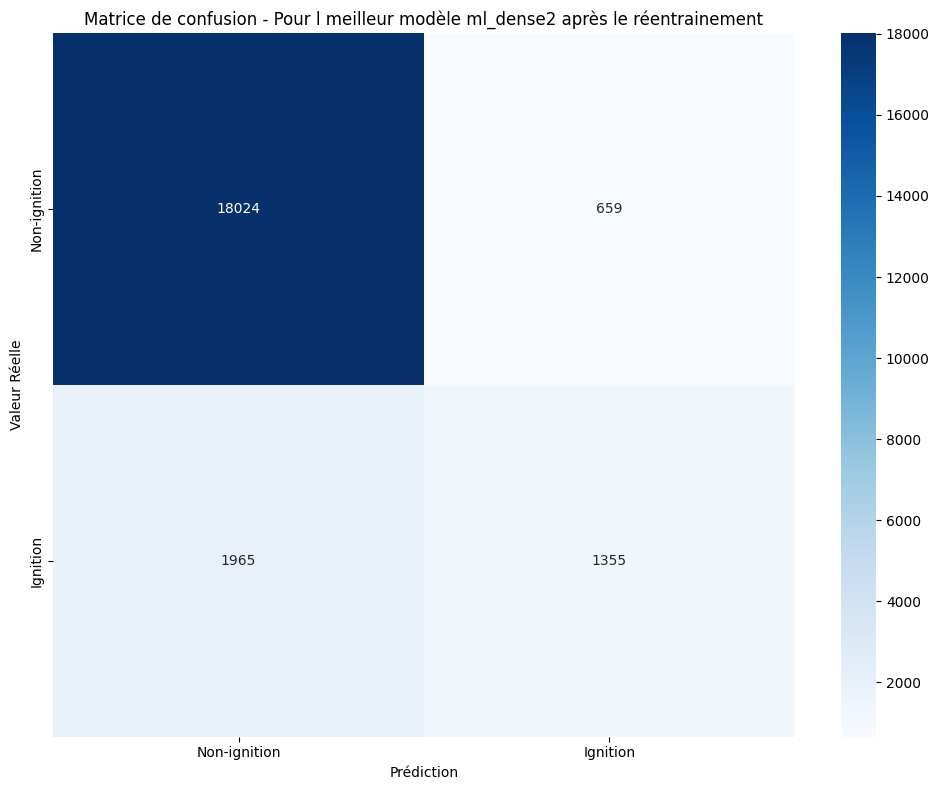

In [9]:
optimise_model(
    model_name='ml_dense2',
    nbr_grid={'couche1': 10, 'couche2': 10},
    cv=5,
    shuffle=True
)


Pour terminer cette étude, nous avons une conclusion similaire qu'avec une couche dense. 

**Conclusion**

Le modèle RandomForest est le modèle le plus performant en termes de précision et de F1-score, tout en maintenant un très faible taux d’erreurs. Ensuite, nous retrouvons le modèle XGBoost qui reste une option robuste si un compromis est acceptable entre faux positifs et faux négatifs. Enfin, nous avons les modèles de réseaux de neurones qui sont moins performants, particulièrement en raison de leur taux élevé de faux négatifs, ce qui pourrait être problématique si la détection des ignitions est importante.